# **Utilizando 3 modelos de classificação para prever predisposição de ataque cardíaco**

# **`EQUIPE BABYLON:`**`Yves Emmanuel && David Londres`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./heart.csv")
df.shape

(303, 14)

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# **Validação e Limpeza dos Dados**

In [4]:
# checando missing values
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

# **Análise Exploratória de Dados**

### **Gráficos de Frequência**

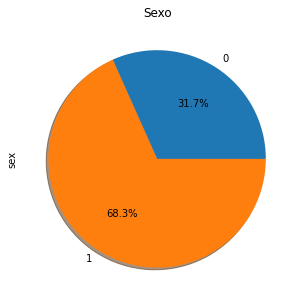

In [5]:
# 1 = masculino
# 0 = feminino
df.groupby("sex")["sex"].count().plot(kind="pie", autopct="%1.1f%%", shadow=True, figsize=(5, 5), title="Sexo")

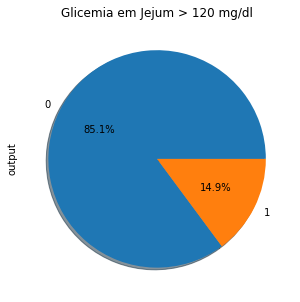

In [6]:
df.groupby("fbs")["output"].count().plot(kind="pie", autopct="%1.1f%%", shadow=True, figsize=(5, 5), title="Glicemia em Jejum > 120 mg/dl")

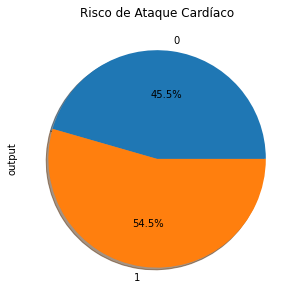

In [7]:
# 1 = alto
# 0 = baixo
df.groupby("output")["output"].count().plot(kind="pie", autopct="%1.1f%%", shadow=True, figsize=(5, 5), title="Risco de Ataque Cardíaco")

### **Gráfico de Correlação**

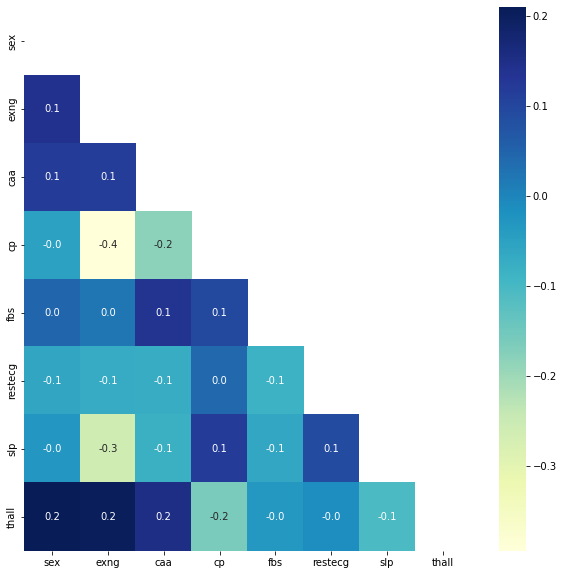

In [8]:
import seaborn as sns

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0, 0])

df_corr = df[["sex", "exng", "caa", "cp", "fbs", "restecg", "slp", "thall", ]].corr().transpose()

color_palette = ["#FFD700", "#C0C0C0"]
mask = np.triu(np.ones_like(df_corr))
sns.heatmap(df_corr, mask=mask, fmt=".1f", annot=True, cmap="YlGnBu")
plt.show()

# **Classificação**

### **Processamento e Divisão dos Dados**

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

categoricos_cols = ["sex", "exng", "caa", "cp", "fbs", "restecg", "slp", "thall"]
continuos_cols = ["age", "trtbps", "chol", "thalachh", "oldpeak"]

X = df.drop(["output"], axis=1)
y = df[["output"]]

st_scaler = StandardScaler()
X = st_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Modelo: **Support Vector Machine**
#### O SVM é um algoritmo que performa bem em conjuntos de dados menores e com altas dimensões, como o nosso.
#### Nesse algoritmo a função do Kernel é utilizada para aumentar a dimensionalidade de sua entrada. **No nosso caso, escolhemos uma função do Kernel linear, que computa o produto interno entre duas observações:** `K(x, xi) = sum(x * xi)`

In [10]:
from sklearn.svm import SVC

model_svm = SVC(kernel="linear", random_state=30)

# fitting
model_svm.fit(X_train, np.ravel(y_train))

# testing
y_pred = model_svm.predict(X_test)

print("Acurácia do SVM: ", accuracy_score(y_test, y_pred))

Acurácia do SVM:  0.8688524590163934


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



### Modelo: **K-Neighbors**
#### Para o número de vizinhos, decidimos buscar pelo melhor valor para esse parâmetro de forma iterativa.

In [12]:
from sklearn.neighbors import  KNeighborsClassifier

k_neighbors = np.arange(1, 11)
optimal_k = None
model_optimal = None
best_accuracy = 0

test_accuracy = np.empty(len(k_neighbors))
train_accuracy = np.empty(len(k_neighbors))

for i, k in enumerate(k_neighbors):
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, np.ravel(y_train))

  # computando a acurácia de teste para K
  y_pred_test = model.predict(X_test)
  test_accuracy[i] = accuracy_score(y_test, y_pred_test)

  # computando a acurácia de treinamento para K
  y_pred_train = model.predict(X_train)
  train_accuracy[i] = accuracy_score(y_train, y_pred_train)

  # buscando o melhor modelo
  if test_accuracy[i] > best_accuracy:
    optimal_k = k
    model_optimal = model
    best_accuracy = test_accuracy[i]

y_pred = model_optimal.predict(X_test)
print("Acurácia do KNN:", accuracy_score(y_test, y_pred))
print("Número Ótimo de Vizinhos:", optimal_k)

Acurácia do KNN: 0.9344262295081968
Número Ótimo de Vizinhos: 6


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        29
           1       0.97      0.91      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.94      0.93        61
weighted avg       0.94      0.93      0.93        61



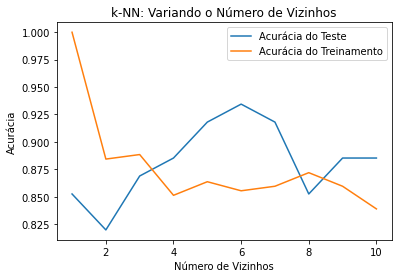

In [14]:
plt.title("k-NN: Variando o Número de Vizinhos")
plt.plot(k_neighbors, test_accuracy, label = "Acurácia do Teste")
plt.plot(k_neighbors, train_accuracy, label = "Acurácia do Treinamento")
plt.legend()
plt.xlabel("Número de Vizinhos")
plt.ylabel("Acurácia")
plt.show()

### Modelo: **Naive Bayes**

In [15]:
# o primeiro modelo
from sklearn.naive_bayes import GaussianNB

model_gnb = GaussianNB()

# fitting
model_gnb.fit(X_train, np.ravel(y_train))

# testing
y_pred = model_gnb.predict(X_test)

print("Acurácia do NaiveBayes:", accuracy_score(y_test, y_pred))

Acurácia do NaiveBayes: 0.8688524590163934


In [16]:
print(model_gnb.class_prior_)

[0.45041322 0.54958678]
